In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib as mpl

import matplotlib.pyplot as plt
from skimage.filters import meijering, sato, frangi, hessian
from skimage.measure import label, regionprops
from skimage import exposure
from sklearn import decomposition
from scipy import ndimage
from scipy.ndimage import gaussian_filter
from scipy.signal import find_peaks
import helpers

In [2]:
filename = 'benoitdata/F20_10_b/6um_jamtveit_att_pag-1.99_3.12_00030.tif'
im = Image.open(filename)
imarr = np.array(im)

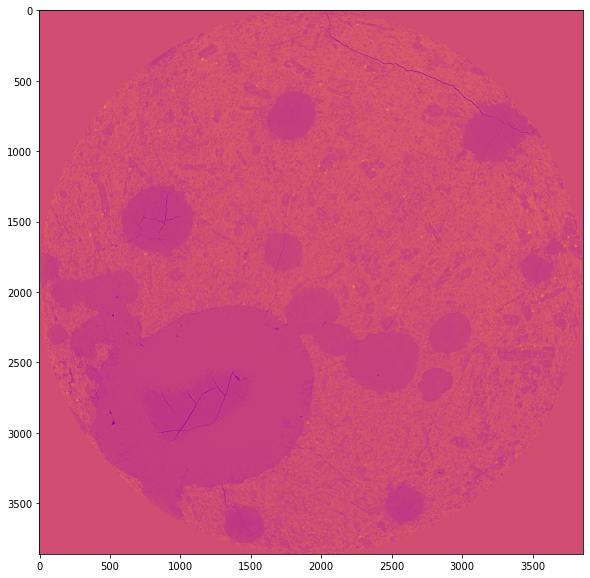

In [3]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(imarr, cmap='plasma')

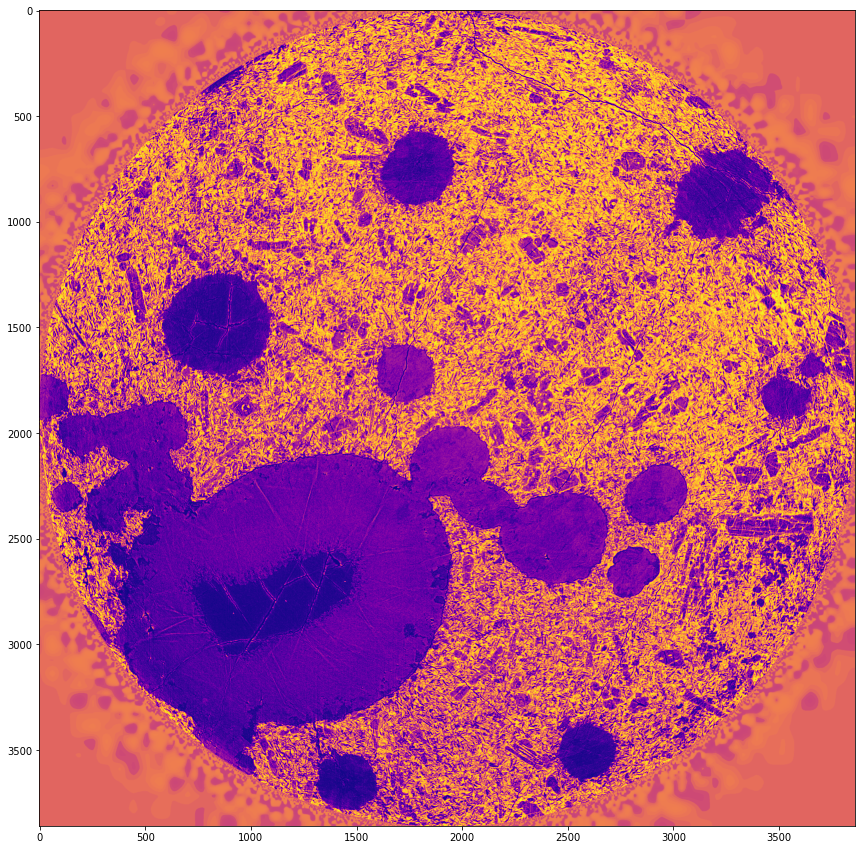

In [4]:
# apply histogram equalization for vesicle picking
# https://scikit-image.org/docs/dev/auto_examples/color_exposure/plot_equalize.html#sphx-glr-auto-examples-color-exposure-plot-equalize-py
imarr_hist = exposure.equalize_hist(imarr)

fig, ax = plt.subplots(figsize=(15, 15))
ax.imshow(imarr_hist, cmap='plasma')


In [5]:
# remove data from outside of core

imarr_maskradius = helpers.remove_data_based_on_radius(imarr, mask_value=np.nan)
imarr_hist = helpers.remove_data_based_on_radius(imarr_hist, mask_value=np.nan)

In [6]:
# try different gaussian blurring based on sigma values

gauss_sigmas = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
blurs = [gaussian_filter(imarr_maskradius, sigma=sigma) for sigma in gauss_sigmas]

In [7]:
# calculate peaks

peaks_etc = [helpers.get_peaks_means_stds(b, height=1e3, width=4) for b in blurs]

# label peaks
peak_labled = [helpers.label_by_peaks(blurs[s-1], peaks_etc[s-1]) for s in gauss_sigmas]

[0 1 2]
0.0    6044389
1.0    3284650
2.0    2360798
dtype: int64
[0 1 2]
0.0    6230191
1.0    2856885
2.0    2602761
dtype: int64
[0 1 2 3]
0.0    5707232
1.0     571126
2.0    2546353
3.0    2865126
dtype: int64
[0 1 2]
0.0    6229230
1.0    2356787
2.0    3103820
dtype: int64
[0 1 2]
0.0    6133257
1.0    2245774
2.0    3310806
dtype: int64
[0 1 2 3]
0.0    5623945
1.0     433259
2.0    2160186
3.0    3472447
dtype: int64
[0 1 2 3 4]
0.0    5434878
1.0      16173
2.0     556876
3.0    2083272
4.0    3598638
dtype: int64
[0 1 2 3]
0.0    5537697
1.0     427964
2.0    2031340
3.0    3692836
dtype: int64
[0 1 2 3]
0.0    5518205
1.0     410047
2.0    1993829
3.0    3767756
dtype: int64
[0 1 2 3 4 5 6 7]
0.0    5005748
1.0      79243
2.0     209053
3.0     185501
4.0     176244
5.0     278390
6.0    1957870
7.0    3797788
dtype: int64


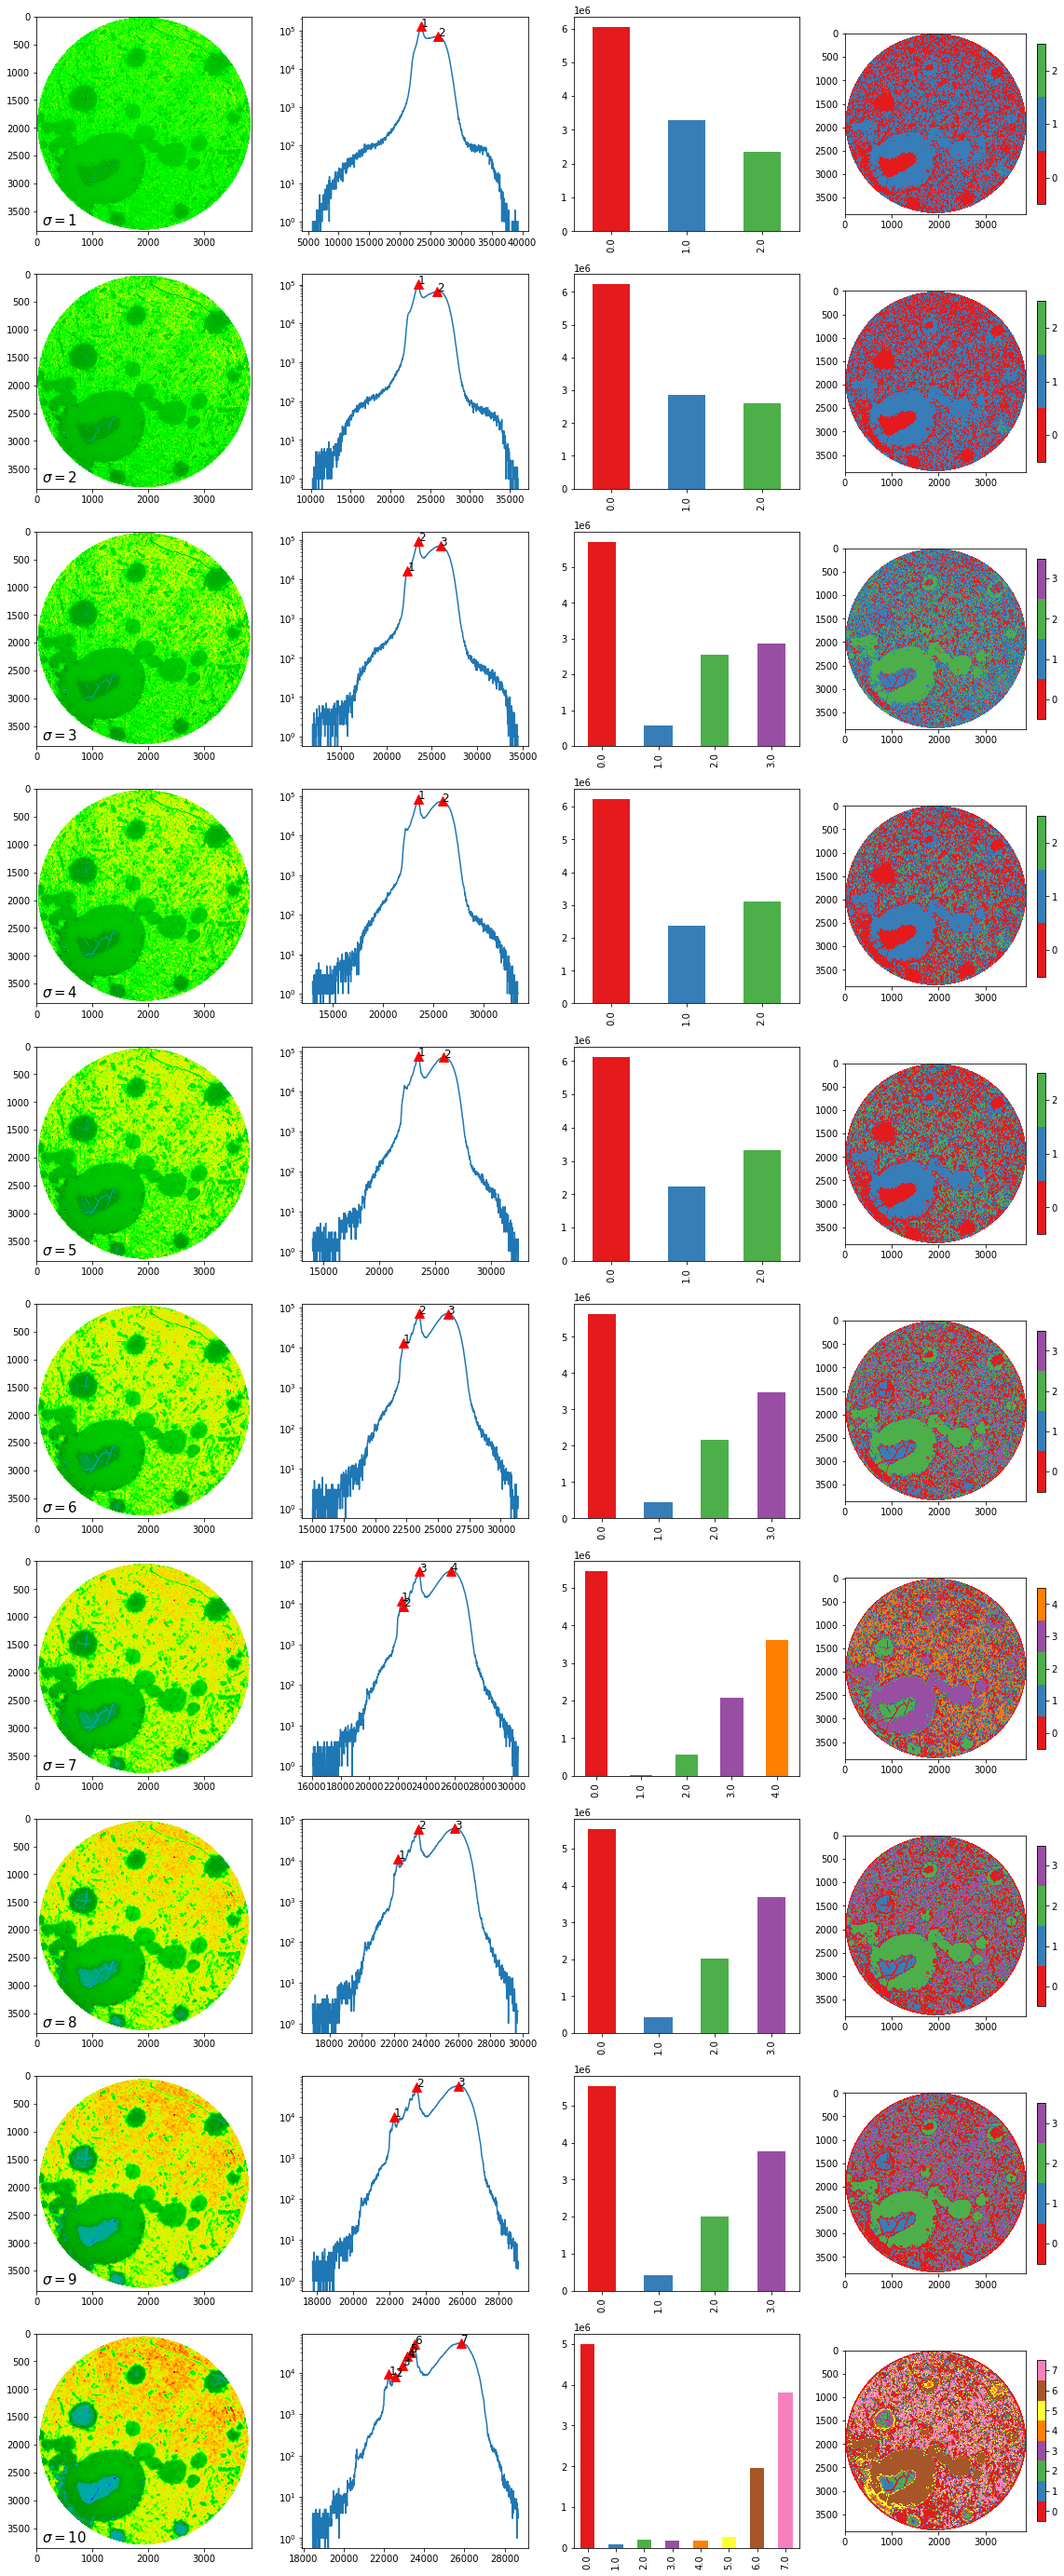

In [8]:
# plot figures that include gaussian blurred image, histogram of CT values with peaks assigned, count of each peak by peak number, and labeled image

fig, ax = plt.subplots(len(gauss_sigmas), 4, figsize=(20, 5*len(gauss_sigmas)))

s = 1
for a, b in zip(ax[:,0], blurs):
    a.imshow(b, cmap='nipy_spectral')
    a.text(s=r'$\sigma=$'+str(s), x=100, y=3750, fontsize=15)
    s+=1
    
for a, p in zip(ax[:,1], peaks_etc):
    x = p['edges'][:-1]
    a.plot(x, p['hist'])
    a.plot(x[p['peaks']], p['hist'][p['peaks']], marker='^', markersize=10, linewidth=0, color='red')
    
    n = 1
    for x, y in zip(x[p['peaks']], p['hist'][p['peaks']]):
        a.text(s=str(n), x=x, y=y, fontsize=12)
        n += 1
    a.set_yscale('log')
    
for a, a2, p, p2 in zip(ax[:,2], ax[:,3], peak_labled, peaks_etc):
    n = len(p2['peaks'])
    bounds = np.arange(0, n+1, 1)
    print(bounds)

    cmap = mpl.colors.LinearSegmentedColormap.from_list('dfg', plt.cm.Set1(bounds), len(bounds))
#     norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
#     norm = mpl.colors.BoundaryNorm(np.arange(0, len(bounds)+1, 1), cmap.N)
    
    bins = p.flatten()
    bincnt = pd.value_counts(bins).sort_index()
    print(bincnt)
    bincnt.plot.bar(ax=a, color=[cmap(b/bounds.max()) for b in bounds])
    
#     cbar = a2.imshow(p, cmap=cmap)
#     cbar = a2.imshow(p, cmap=cmap, norm=norm)
    cbar = a2.imshow(p, cmap=cmap, vmin=0, vmax=bounds.max())
    
    step = (bounds[-1]/bounds.shape[0])/2
    ticks = [(b*bounds.max()/bounds.shape[0])+step for b in bounds]
    
    cbar = fig.colorbar(cbar, ax=a2, shrink=0.75, ticks=ticks)
    cbar.ax.set_yticklabels(bounds)
    
# fig.tight_layout()
# fig.savefig('boom.png', dpi=500, bbox_inches='tight')

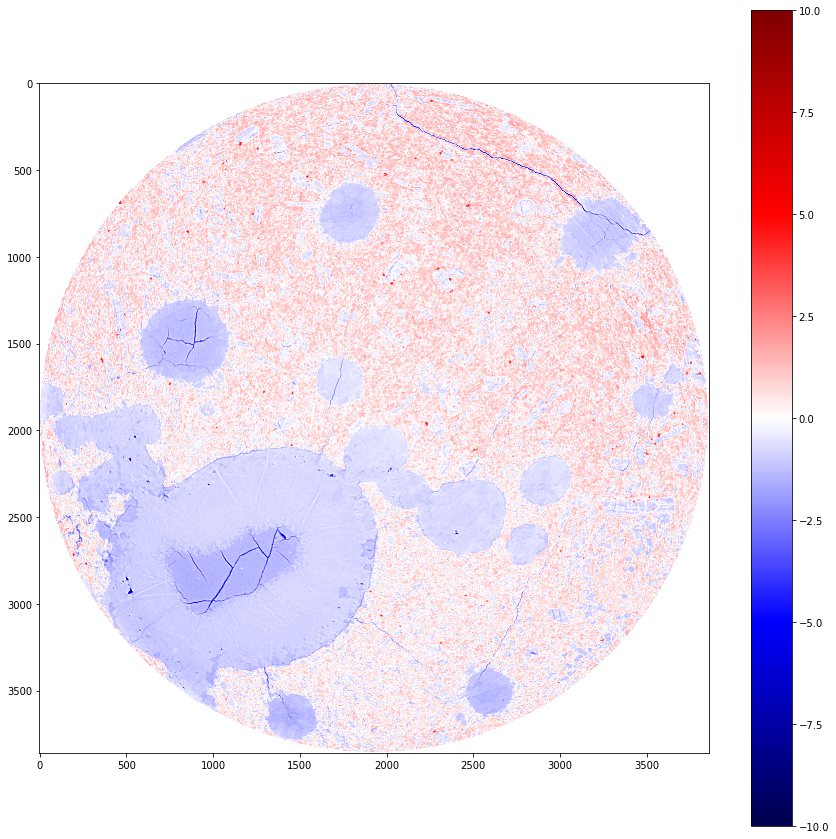

In [9]:
# calculate global mean and rescale values

zim = helpers.zscore(imarr_maskradius)

fig, ax = plt.subplots(figsize=(15, 15))
cbar = ax.imshow(zim, cmap='seismic', vmin=-10, vmax=10)
fig.colorbar(cbar)

In [10]:
# filter out all data that is not fracture

zim_remove = zim.copy()
zim_remove[zim_remove > -1.75] = 0

x1, y1 = zim_remove.nonzero()

zeros = np.zeros_like(zim_remove)

zeros[x1, y1] = 1

'\nThis more or less removes all data except for some noise and \nthe fractures. Using a smoothing algorithm to get rid of the rest\nof the noise should leave only the porosity.\n'

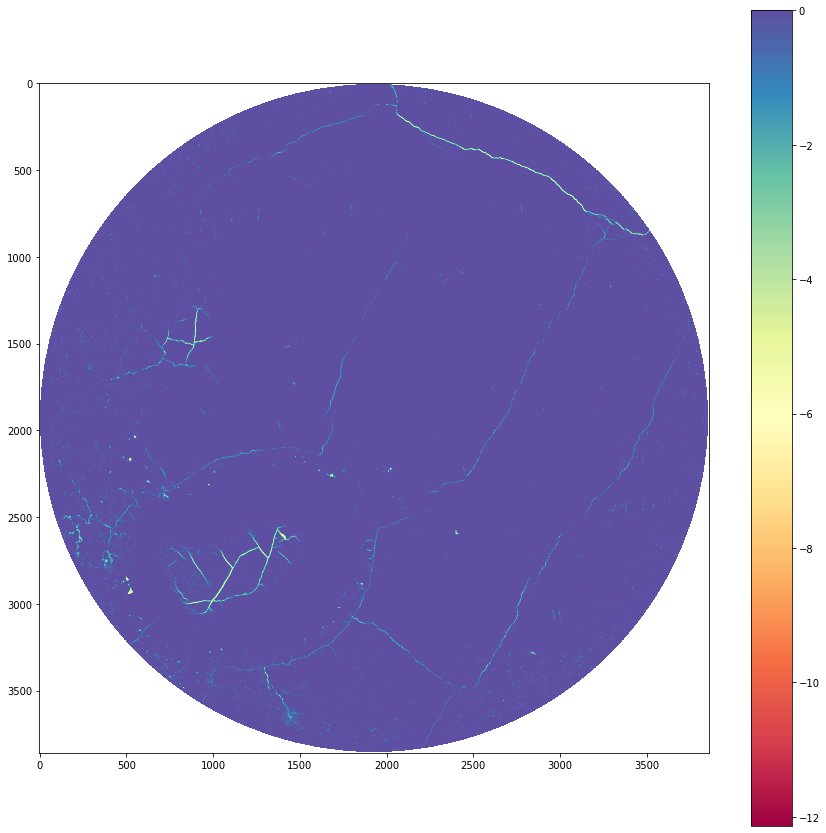

In [11]:
fig, ax = plt.subplots(figsize=(15, 15))
cbar = ax.imshow(zim_remove, cmap='Spectral')
fig.colorbar(cbar)

"""
This more or less removes all data except for some noise and 
the fractures. Using a smoothing algorithm to get rid of the rest
of the noise should leave only the porosity.
"""

In [12]:
# replace all data as either 1 or 0 for fracture identification

# footprint condition says value should be greater
# in all directions
footprint1 = np.array(
    [[1, 1, 1]
    ,[1, 0, 1]
    ,[1, 1, 1]]
)

footprint2 = np.array(
    [[1, 1, 1, 1, 1]
    ,[1, 1, 1, 1, 1]
    ,[1, 1, 0, 1, 1]
    ,[1, 1, 1, 1, 1]
    ,[1, 1, 1, 1, 1]]
)

# creates a window based on the given footprint
# to compare neighbors and replace values on 
# nearest maximum value
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.maximum_filter.html
newim = ndimage.median_filter(zeros, footprint=footprint1, mode='constant')
newim = ndimage.maximum_filter(newim, footprint=footprint2, mode='constant')
# newim = ndimage.maximum_filter(zim_remove, footprint=footprint2, mode='constant')

fig, ax = plt.subplots(figsize=(15, 15))

imlabeled = helpers.remove_data_based_on_radius(newim, mask_value=np.nan)

cbar = ax.imshow(imlabeled, cmap='cool')

fig.colorbar(cbar)


NameError: name 'ndimage' is not defined